# Analyse der Gesamttabelle

In [1]:
# Import der notwendigen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Konfiguration
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

stores = pd.read_csv("data/stores.csv")
products = pd.read_csv("data/products.csv")
transactions = pd.read_parquet("data/transactions_train_1.parquet")
transaction_lines = pd.read_parquet("data/transaction_lines_train_1.parquet")

## Join

In [2]:
# ID-Spallten für Join umbenennen
stores.rename(columns={"id": "store_id"}, inplace=True)
products.rename(columns={"id": "product_id"}, inplace=True)
transactions.rename(columns={"id": "transaction_id"}, inplace=True)

# Transaction-Tabelle mit Store-Tabelle  joinen
joined_transactions = transactions.merge(stores, on="store_id", how="left")

# Transaction_lines-Tabelle mit Product-Tabelle joinen
joined_transactionlines = transaction_lines.merge(products, on="product_id", how="left")

## Tabelle joined_transactions

In [3]:
# Datentypen ansehen
joined_transactions.dtypes

transaction_id               object
store_id                     object
cash_desk                     int64
transaction_start    datetime64[us]
transaction_end      datetime64[us]
total_amount                float64
n_lines                       int64
payment_medium               object
customer_feedback           float64
damage                      float64
label                        object
opening_date                 object
location                     object
state                        object
urbanization                 object
sco_introduction             object
dtype: object

In [4]:
joined_transactions.shape

(1558245, 16)

In [5]:
# Tabelle ansehen
joined_transactions.head(3)

,transaction_id,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,customer_feedback,damage,label,opening_date,location,state,urbanization,sco_introduction
0,5bedf771-f016-41a7-ab89-f40e7f6be955,b0973ffa-ce15-41e0-9de7-1390598e24f2,0,2022-02-02 08:00:12,2022-02-02 08:01:02.825563,52.26,6,CREDIT_CARD,NaN,NaN,UNKNOWN,2005-06-02,Berlin,Berlin,RURAL,2022-02-02
1,21ff1406-dbc4-41a7-8429-836cbf96d853,b0973ffa-ce15-41e0-9de7-1390598e24f2,1,2022-02-02 08:05:06,2022-02-02 08:05:30.565876,1.47,1,CREDIT_CARD,NaN,NaN,UNKNOWN,2005-06-02,Berlin,Berlin,RURAL,2022-02-02
2,b642f9b6-43b5-413d-ad08-b4bf4b664b52,b0973ffa-ce15-41e0-9de7-1390598e24f2,2,2022-02-02 08:07:12,2022-02-02 08:11:29.434607,363.87,37,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02


Löschen der Spalten 'opening_date' und 'sco_introduction' aufgrund Irrelevanz

In [6]:
joined_transactions.drop(columns=['opening_date', 'sco_introduction'], inplace=True)

Spalten mit fehlenden Werten

In [7]:
missing_values = joined_transactions.isnull().sum()
print(missing_values)

transaction_id             0
store_id                   0
cash_desk                  0
transaction_start          0
transaction_end            0
total_amount               0
n_lines                    0
payment_medium             0
customer_feedback    1449915
damage               1402553
label                      0
location                   0
state                      0
urbanization               0
dtype: int64


--> 'customer_Feedback' hat rund 96% und 'damage' rund 93% fehlende Werte. 

'customer_feedback'

In [8]:
# Absolute Häufigkeit (inkl. NaN)
feedback_counts = joined_transactions['customer_feedback'].value_counts(dropna=False)

# Prozentuale Verteilung
feedback_percent = joined_transactions['customer_feedback'].value_counts(normalize=True, dropna=False) * 100

# Kombinieren in DataFrame
feedback_summary = pd.DataFrame({
    'Anzahl': feedback_counts,
    'Prozent': feedback_percent.round(2)
})

print(feedback_summary)

                    Anzahl  Prozent
customer_feedback                  
NaN                1449915    93.05
10.0                 83637     5.37
9.0                   5431     0.35
8.0                   4473     0.29
7.0                   3714     0.24
6.0                   2816     0.18
1.0                   2516     0.16
5.0                   2126     0.14
4.0                   1620     0.10
3.0                   1086     0.07
2.0                    911     0.06


In [9]:
# Korrelation zum Label prüfen
pd.crosstab(joined_transactions['customer_feedback'], joined_transactions['label'], normalize='index') * 100

label,FRAUD,NORMAL,UNKNOWN
customer_feedback,,,
1.0,0.198728,9.379968,90.421304
2.0,0.000000,9.110867,90.889133
3.0,0.276243,10.773481,88.950276
4.0,0.000000,8.888889,91.111111
5.0,0.235183,9.689558,90.075259
6.0,0.106534,9.943182,89.950284
7.0,0.107701,9.962305,89.929995
8.0,0.089425,10.283926,89.626649
9.0,0.110477,9.206408,90.683115


In [10]:
pd.crosstab(joined_transactions['customer_feedback'], joined_transactions['label'])


label,FRAUD,NORMAL,UNKNOWN
customer_feedback,,,
1.0,5,236,2275
2.0,0,83,828
3.0,3,117,966
4.0,0,144,1476
5.0,5,206,1915
6.0,3,280,2533
7.0,4,370,3340
8.0,4,460,4009
9.0,6,500,4925


Doppelte Zeilen und IDs

In [11]:
# Prüft, ob vollständige Duplikate (identische Zeilen) existieren
duplicate_rows = joined_transactions[joined_transactions.duplicated()]
print(f"Anzahl vollständig doppelter Zeilen: {len(duplicate_rows)}")


Anzahl vollständig doppelter Zeilen: 0


In [12]:
# Prüft, ob die transaction_id mehrfach vorkommt
duplicate_ids = joined_transactions['transaction_id'].duplicated().sum()
print(f"Anzahl mehrfach vorkommender transaction_ids: {duplicate_ids}")

Anzahl mehrfach vorkommender transaction_ids: 0


### Explorative Datenanalyse

In [4]:
# Entferne Zeilen mit label == "UNKNOWN"
joined_transactions = joined_transactions[joined_transactions['label'].isin(['NORMAL', 'FRAUD'])].copy()

In [14]:
# --- Basisübersicht ---
print("\nDatenübersicht:")
print(joined_transactions.info())
print("\nStatistische Beschreibung:")
print(joined_transactions.describe(include='all'))


Datenübersicht:
<class 'pandas.core.frame.DataFrame'>
Index: 155692 entries, 2 to 1558199
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_id     155692 non-null  object        
 1   store_id           155692 non-null  object        
 2   cash_desk          155692 non-null  int64         
 3   transaction_start  155692 non-null  datetime64[us]
 4   transaction_end    155692 non-null  datetime64[us]
 5   total_amount       155692 non-null  float64       
 6   n_lines            155692 non-null  int64         
 7   payment_medium     155692 non-null  object        
 8   customer_feedback  10641 non-null   float64       
 9   damage             155692 non-null  float64       
 10  label              155692 non-null  object        
 11  location           155692 non-null  object        
 12  state              155692 non-null  object        
 13  urbanization       155692 non-n


Verteilung der Zielvariable 'label':
label
NORMAL    0.967885
FRAUD     0.032115
Name: proportion, dtype: float64


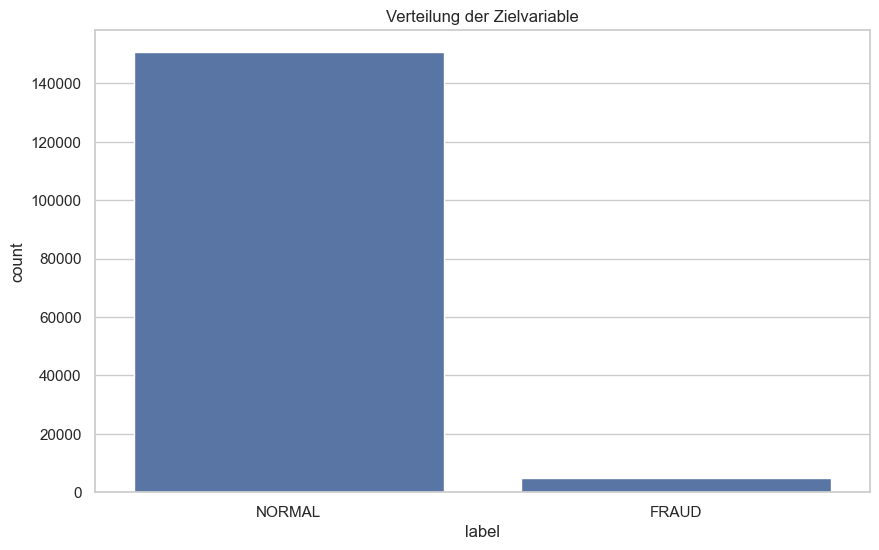

In [15]:
# --- Verteilung der Zielvariable ---
print("\nVerteilung der Zielvariable 'label':")
print(joined_transactions['label'].value_counts(normalize=True))
sns.countplot(data=joined_transactions, x='label')
plt.title('Verteilung der Zielvariable')
plt.show()

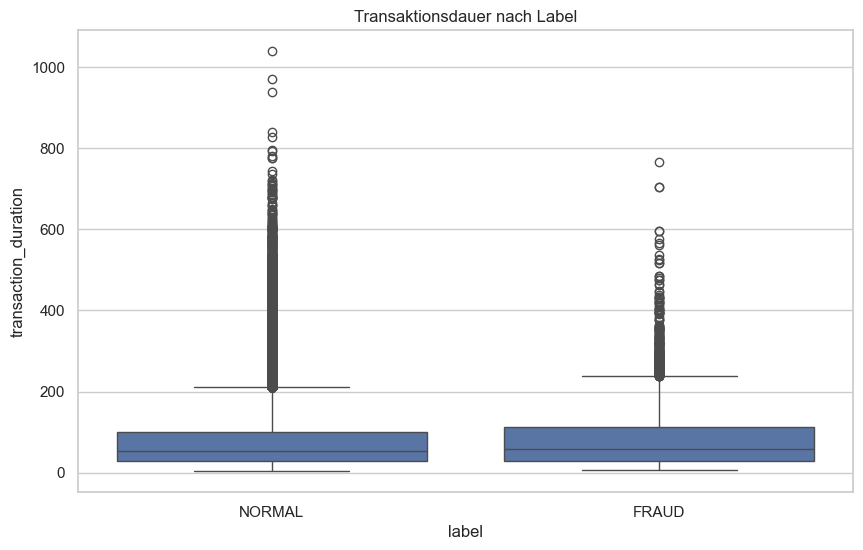

In [17]:
# --- Transaktionsdauer ---
joined_transactions['transaction_duration'] = (joined_transactions['transaction_end'] - joined_transactions['transaction_start']).dt.total_seconds()
sns.boxplot(data=joined_transactions, x='label', y='transaction_duration')
plt.title('Transaktionsdauer nach Label')
plt.show()

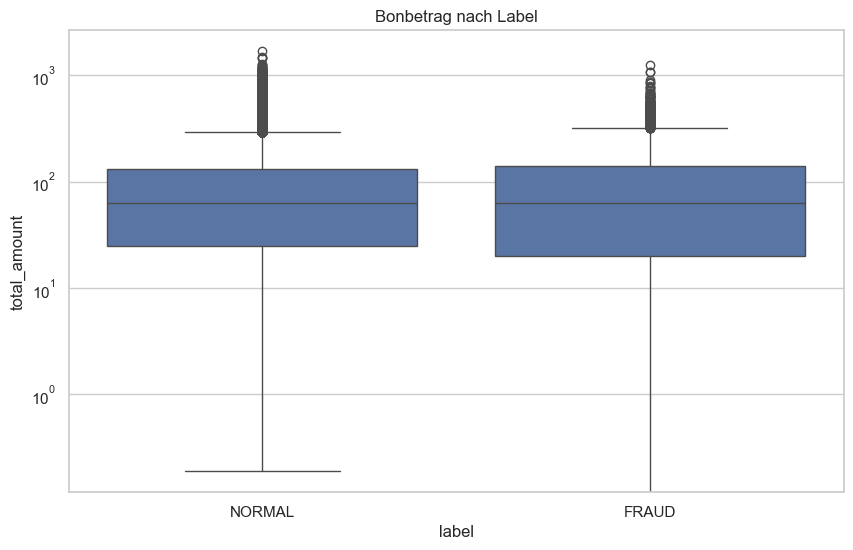

In [18]:
# --- Total Amount ---
sns.boxplot(data=joined_transactions, x='label', y='total_amount')
plt.title('Bonbetrag nach Label')
plt.yscale('log')
plt.show()

In [6]:
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.preprocessing import LabelEncoder

In [20]:
# Transaktionsdauer als Feature anlegen
joined_transactions['transaction_duration'] = (joined_transactions['transaction_end'] - joined_transactions['transaction_start']).dt.total_seconds()

In [21]:
# --- Zielvariable in binäres Format bringen ---
le = LabelEncoder()
joined_transactions['label_bin'] = le.fit_transform(joined_transactions['label'])  # FRAUD = 1, NORMAL = 0

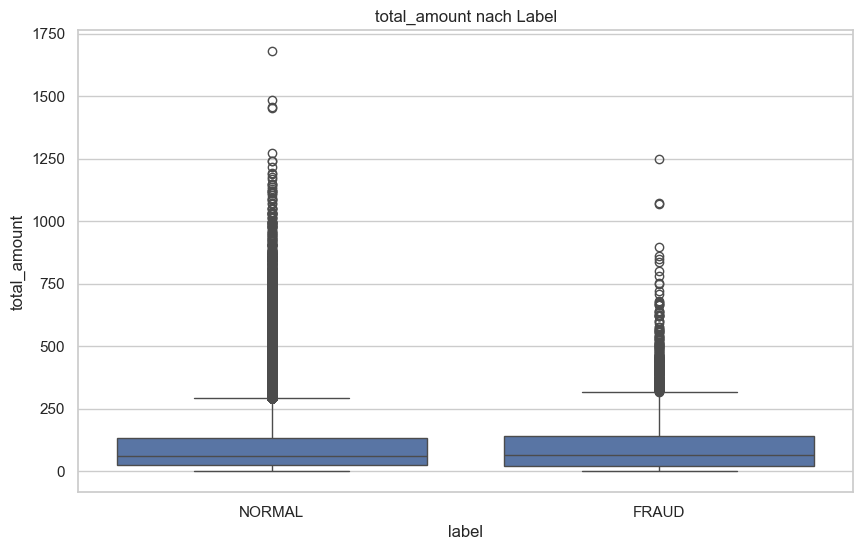

total_amount: Mann-Whitney-U-Test p-Wert = 0.0412


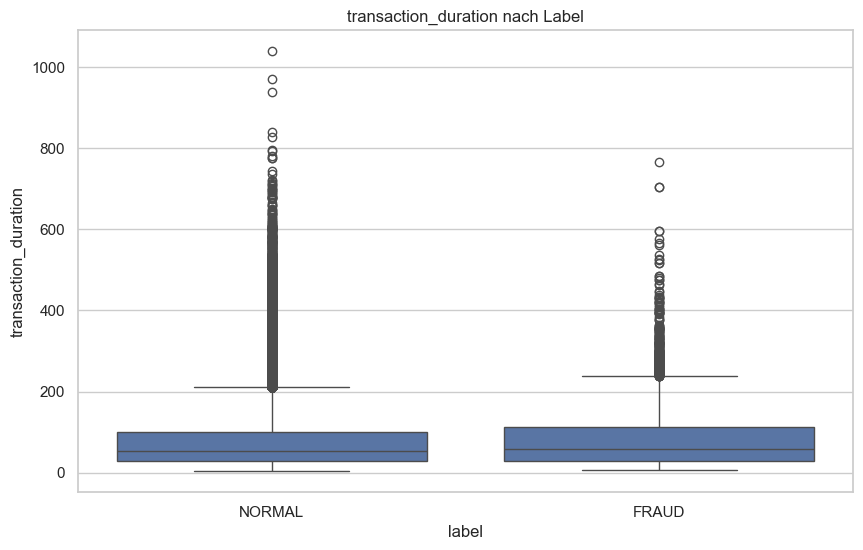

transaction_duration: Mann-Whitney-U-Test p-Wert = 0.0000


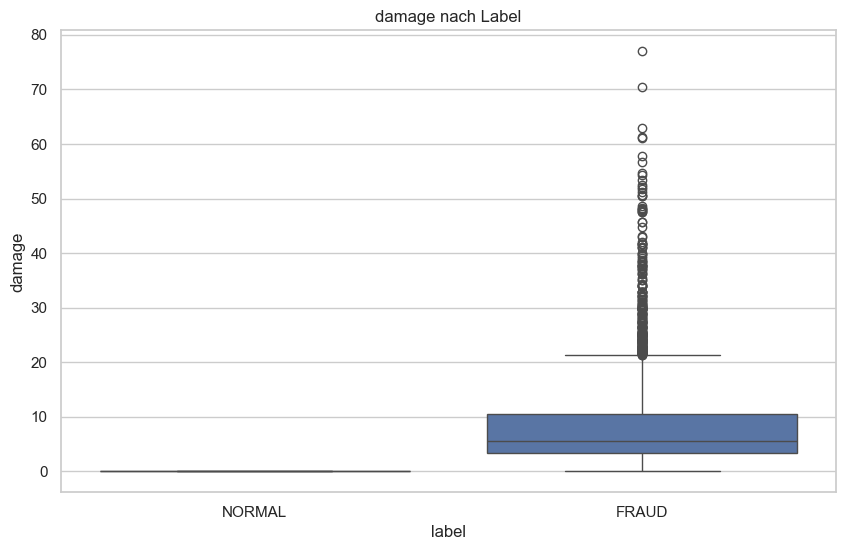

damage: Mann-Whitney-U-Test p-Wert = 0.0000


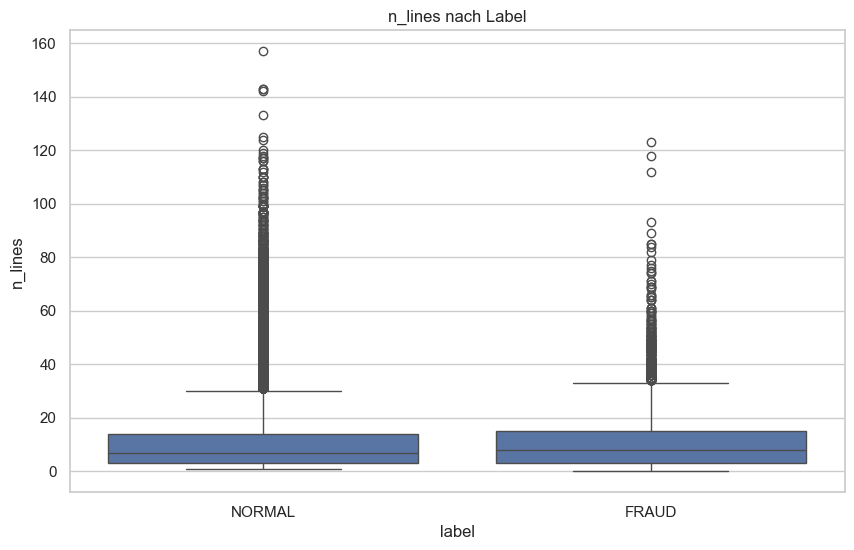

n_lines: Mann-Whitney-U-Test p-Wert = 0.0002


In [23]:
# --- Analyse numerischer Features ---
numerical_features = ['total_amount', 'transaction_duration', 'damage', 'n_lines']

for feature in numerical_features:
    sns.boxplot(data=joined_transactions, x='label', y=feature)
    plt.title(f'{feature} nach Label')
    plt.show()

    fraud_values = joined_transactions[joined_transactions['label'] == 'FRAUD'][feature].dropna()
    normal_values = joined_transactions[joined_transactions['label'] == 'NORMAL'][feature].dropna()

    stat, p = mannwhitneyu(fraud_values, normal_values, alternative='two-sided')
    print(f"{feature}: Mann-Whitney-U-Test p-Wert = {p:.4f}")


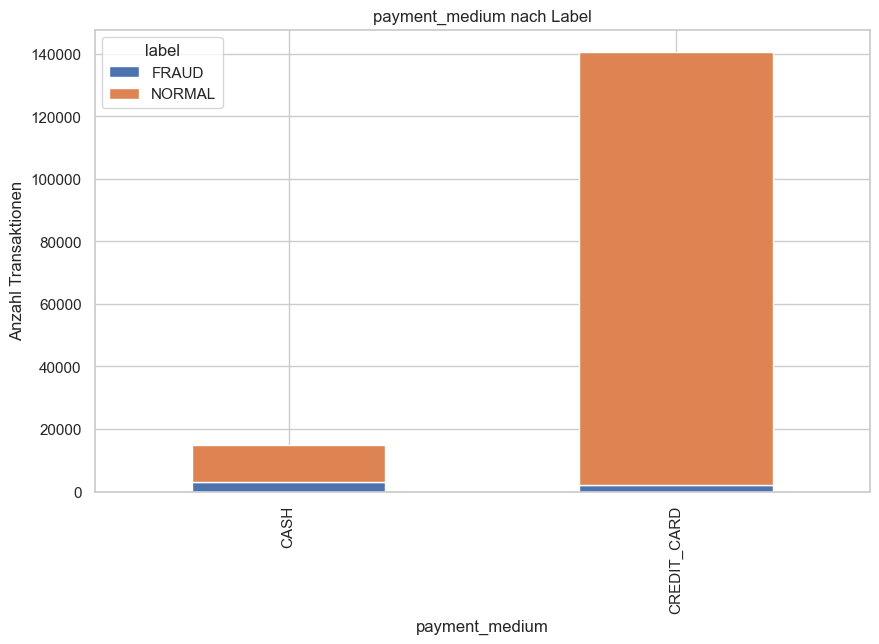

payment_medium: Chi²-Test p-Wert = 0.0000


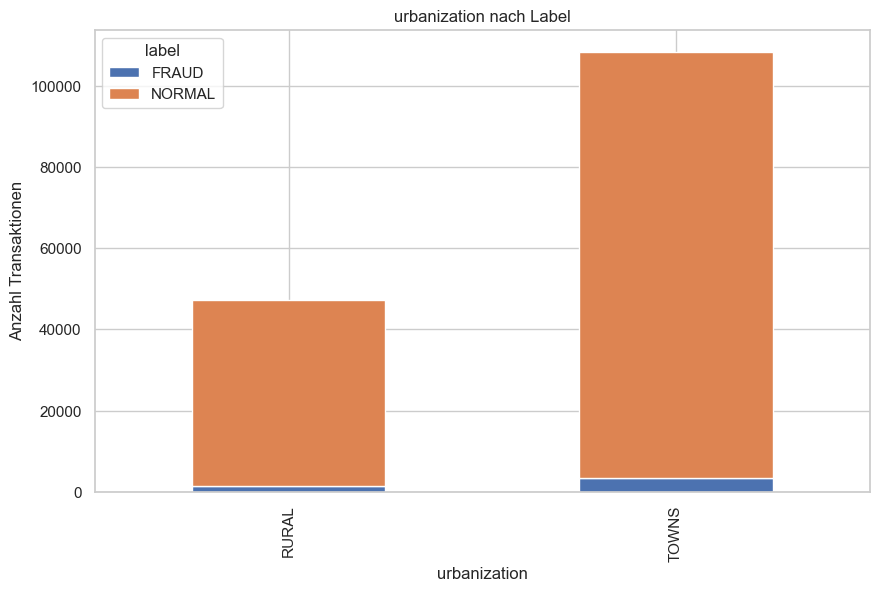

urbanization: Chi²-Test p-Wert = 0.7464


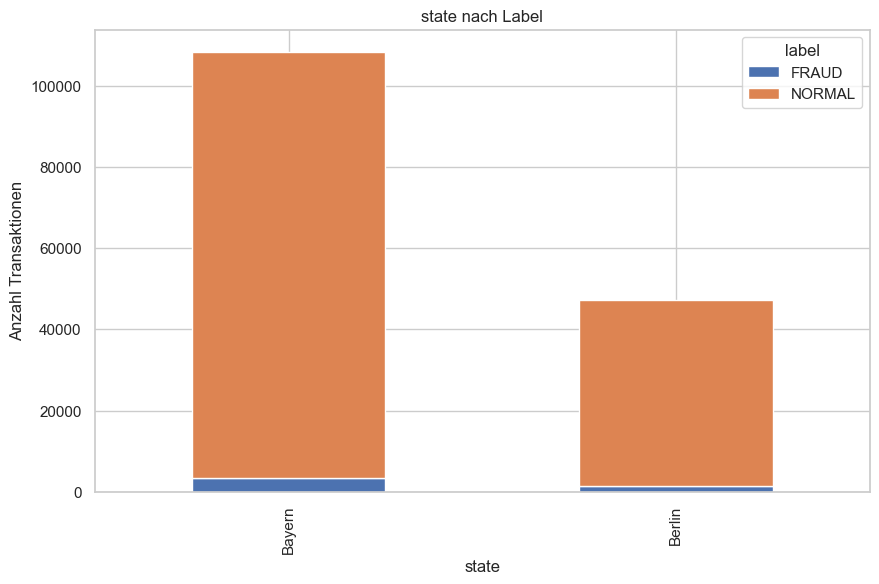

state: Chi²-Test p-Wert = 0.7464


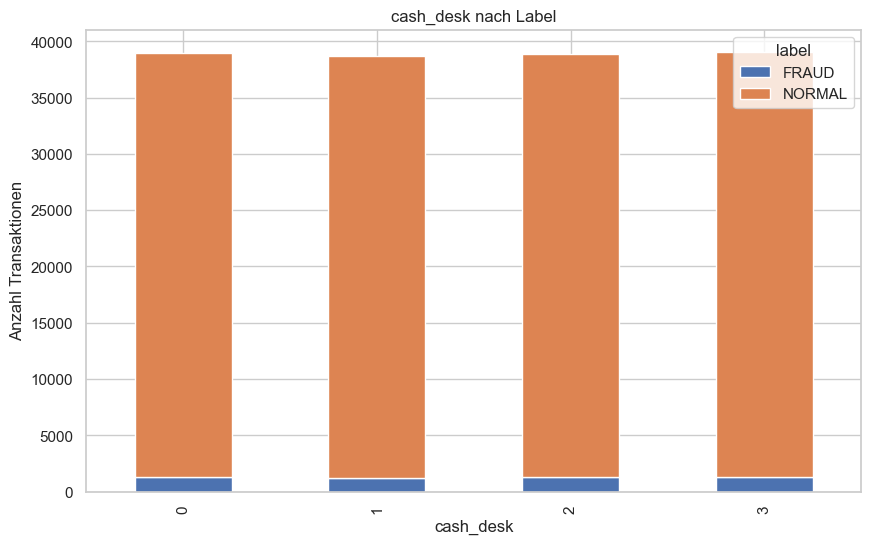

cash_desk: Chi²-Test p-Wert = 0.6781


In [7]:
# --- Analyse kategorischer Features ---
categorical_features = ['payment_medium', 'urbanization', 'state', 'cash_desk']

for feature in categorical_features:
    ctab = pd.crosstab(joined_transactions[feature], joined_transactions['label'])
    ctab.plot(kind='bar', stacked=True)
    plt.title(f'{feature} nach Label')
    plt.ylabel('Anzahl Transaktionen')
    plt.show()

    chi2, p, dof, expected = chi2_contingency(ctab)
    print(f"{feature}: Chi²-Test p-Wert = {p:.4f}")


In [25]:
print(joined_transactions.groupby('label')['total_amount'].median())


label
FRAUD     63.53
NORMAL    62.64
Name: total_amount, dtype: float64


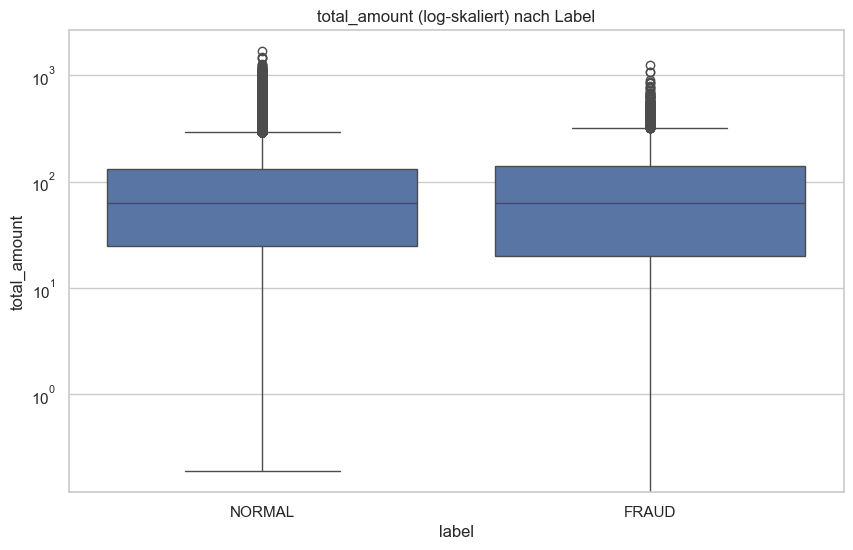

In [26]:
# Visualisierung mit log-Skalierung
sns.boxplot(data=joined_transactions, x='label', y='total_amount')
plt.yscale('log')
plt.title('total_amount (log-skaliert) nach Label')
plt.show()


--> In der explorativen Analyse zeigte total_amount einen signifikanten Unterschied zwischen betrügerischen und normalen Transaktionen (p = 0.0412, Mann-Whitney-U). Dies spricht für eine potenzielle Relevanz des Betrags als Merkmal zur Klassifikation.

Zusammenhang Feesbach vs. Label

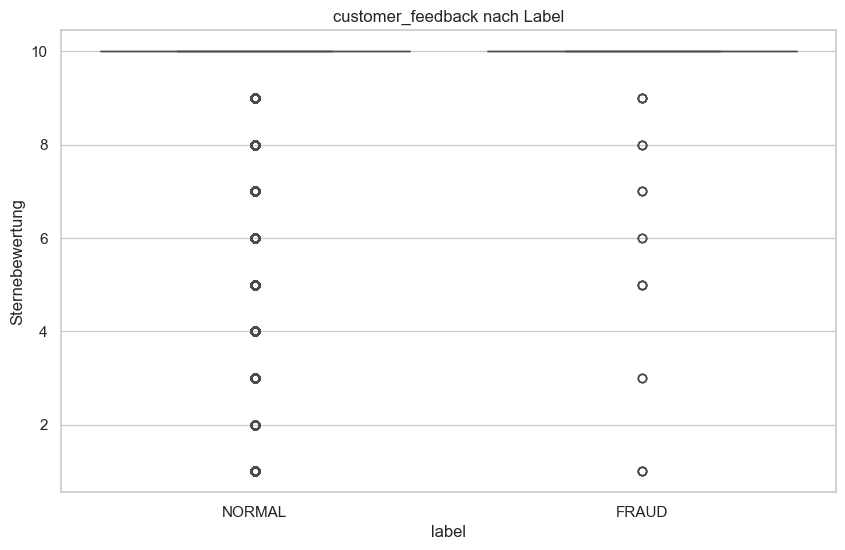

customer_feedback: Mann-Whitney-U-Test p-Wert = 0.0000


In [27]:
# Nur Transaktionen mit Feedback analysieren
feedback_df = joined_transactions[~joined_transactions['customer_feedback'].isnull()]

# Boxplot: Feedback nach Label
sns.boxplot(data=feedback_df, x='label', y='customer_feedback')
plt.title('customer_feedback nach Label')
plt.ylabel('Sternebewertung')
plt.show()

# Mann-Whitney-U-Test
fraud_fb = feedback_df[feedback_df['label'] == 'FRAUD']['customer_feedback']
normal_fb = feedback_df[feedback_df['label'] == 'NORMAL']['customer_feedback']
stat, p = mannwhitneyu(fraud_fb, normal_fb, alternative='two-sided')
print(f"customer_feedback: Mann-Whitney-U-Test p-Wert = {p:.4f}")


Zusammenhang Zahlungsmittel vs Label

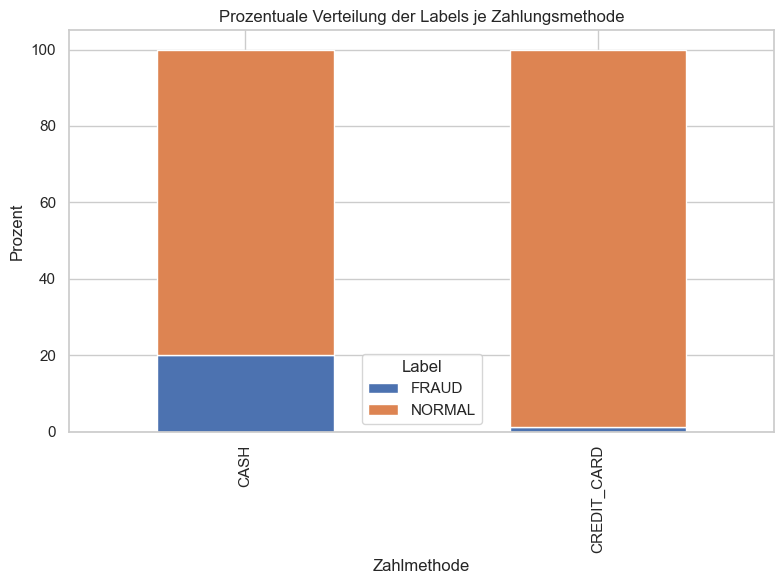

In [9]:
# Kreuztabelle: Anteil der Labels je Zahlungsmethode (normalisiert pro Zahlungsmethode)
cross_tab = pd.crosstab(joined_transactions['payment_medium'], joined_transactions['label'], normalize='index') * 100

# Plot
cross_tab.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Prozentuale Verteilung der Labels je Zahlungsmethode')
plt.ylabel('Prozent')
plt.xlabel('Zahlmethode')
plt.legend(title='Label')
plt.tight_layout()
plt.show()


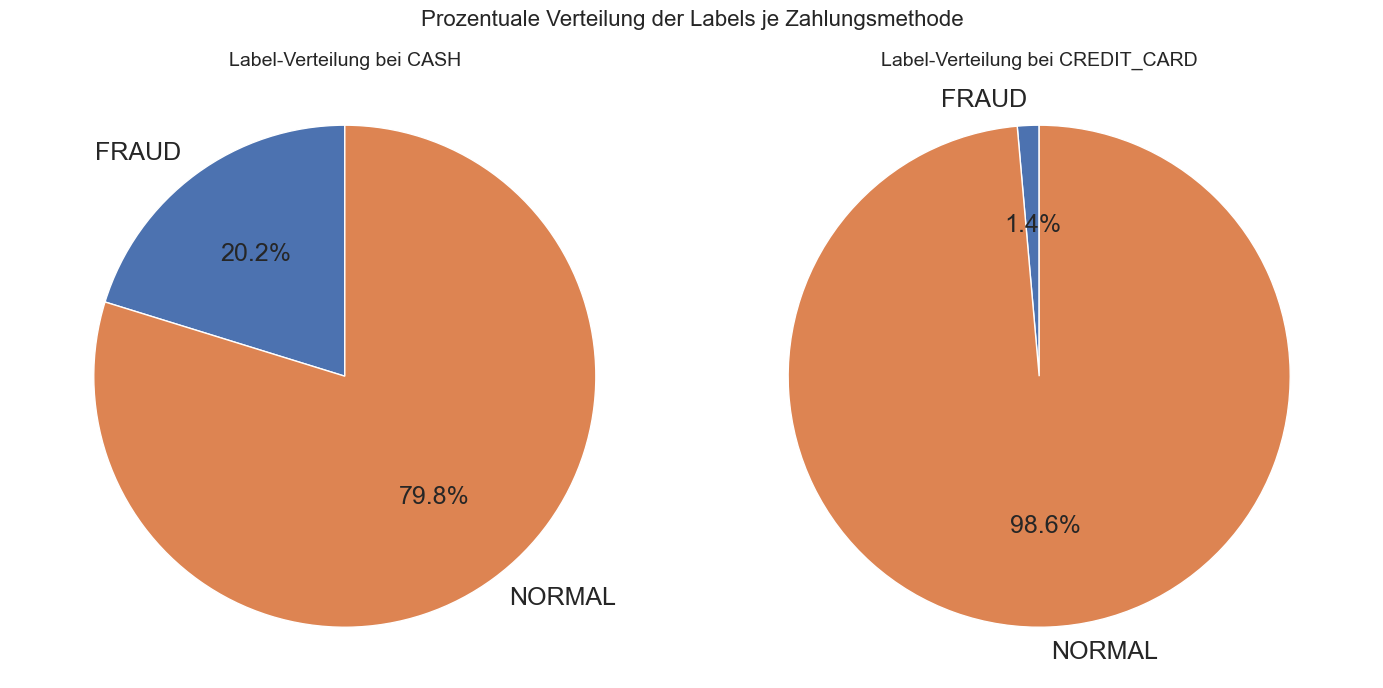

In [15]:
# Gruppieren und Prozentanteile berechnen
grouped = joined_transactions.groupby('payment_medium')['label'].value_counts(normalize=True).unstack() * 100

# Plot-Setup mit größerer Schrift
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # Größerer Plot

# Pie Chart für CASH
axes[0].pie(
    grouped.loc['CASH'],
    labels=grouped.columns,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 18}  # größere Schrift
)
axes[0].set_title('Label-Verteilung bei CASH', fontsize=14)
axes[0].axis('equal')

# Pie Chart für CREDIT_CARD
axes[1].pie(
    grouped.loc['CREDIT_CARD'],
    labels=grouped.columns,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 18}  # größere Schrift
)
axes[1].set_title('Label-Verteilung bei CREDIT_CARD', fontsize=14)
axes[1].axis('equal')

plt.suptitle('Prozentuale Verteilung der Labels je Zahlungsmethode', fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
# Kontingenztabelle erstellen (absolute Häufigkeiten)
contingency_table = pd.crosstab(joined_transactions['payment_medium'], joined_transactions['label'])

# Chi²-Test durchführen
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Ergebnisse ausgeben
print("Chi²-Statistik:", chi2)
print("p-Wert:", p)
print("Freiheitsgrade:", dof)
print("\nErwartete Häufigkeiten unter H0:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))


Chi²-Statistik: 15467.606163792465
p-Wert: 0.0
Freiheitsgrade: 1

Erwartete Häufigkeiten unter H0:
label                 FRAUD         NORMAL
payment_medium                            
CASH             482.298384   14535.701616
CREDIT_CARD     4517.701616  136156.298384


• **Zusammenhang zum Zahlungsmittel:** Das Merkmal payment_medium zeigte einen hochsignifikanten Zusammenhang mit der Zielvariable (p < 0.0001, Chi²-Test). Insbesondere ist ein überproportionaler Anteil betrügerischer Transaktionen bei Barzahlung zu beobachten. Dieses Merkmal wird daher als potenziell erklärungsrelevant für spätere Modellierungen berücksichtigt.

• **Zusammenhang zwischen Gesamtbetrag und Label:** In der explorativen Analyse zeigte total_amount einen signifikanten Unterschied zwischen betrügerischen und normalen Transaktionen (p = 0.0412, Mann-Whitney-U). Dies spricht für eine potenzielle Relevanz des Betrags als Merkmal zur Klassifikation

• **Zusammenhang zur Transaktionsdauer:** Das Merkmal transaction_duration zeigte in der explorativen Analyse eine hochsignifikante Differenz zwischen den Klassen FRAUD und NORMAL (p < 0.0001, Mann-Whitney-U). Dies lässt auf ein potenziell nützliches Prädiktor-Merkmal für spätere Klassifikationsverfahren schließen.
Visuell: Fraud-Transaktionen scheinen im Median leicht kürzer, aber mit teils hohen Ausreißern. Mögliche Erklärung: Betrüger:innen „eilen“ beim Scan-Vorgang – oder pausieren ungewöhnlich lange (z. B. bei Manipulation?).

• **Zusammenhang zur Warenkorbgröße:** Die Variable n_lines (Anzahl gescannter Positionen) weist mit p = 0.0002 einen signifikanten Unterschied zwischen normalen und betrügerischen Transaktionen auf. Dies deutet darauf hin, dass Fraud-Fälle im Mittel (Median) mehr Positionen enthalten.

• **Zusammenhang zur Urbanisierung:** Im Rahmen der explorativen Analyse ergab sich für das Merkmal urbanization kein signifikanter Zusammenhang mit der Zielvariable (p = 0.7464, Chi²-Test). Das Merkmal wird daher als potenziell irrelevant für die Klassifikation betrachtet.

• **Zusammenhang zum Bundesland:** Für das Merkmal state (Bundesland) zeigte sich kein signifikanter Zusammenhang mit der Zielvariable (p = 0.7464, Chi²-Test). Es wird daher als nicht erklärungsrelevant eingestuft und kann in der Merkmalsauswahl ignoriert werden.

• **Zusammenhang zur Kasse:** Das Merkmal cash_desk zeigte in der Chi²-Analyse keinen signifikanten Zusammenhang mit der Zielvariable (p = 0.6781). Es liefert damit keinen Mehrwert für die spätere Modellbildung.

• **Zusammenhang zum Customer Feedback:** Die Variable customer_feedback, welche nur bei Self-Checkout-Transaktionen verfügbar ist, zeigt einen hochsignifikanten Zusammenhang mit dem Transaktionslabel (p < 0.0001, Mann-Whitney-U-Test). Die Daten legen nahe, dass betrügerische Transaktionen im Durchschnitt deutlich schlechter bewertet werden, was auf ein erhöhtes subjektives Unbehagen oder Misstrauen der Kundschaft hinweisen könnte.

## Tabelle joined_transactionlines

In [28]:
joined_transactionlines.dtypes

id                                 int64
transaction_id                    object
product_id                        object
timestamp                 datetime64[us]
pieces_or_weight                 float64
sales_price                      float64
was_voided                          bool
camera_product_similar            object
camera_certainty                 float64
base_product_id                   object
category                          object
price                            float64
popularity                       float64
valid_from                        object
valid_to                          object
sold_by_weight                    object
weight                           float64
age_restricted                    object
dtype: object

In [29]:
joined_transactionlines.shape

(16620157, 18)

In [30]:
joined_transactionlines.head(3)

,id,transaction_id,product_id,timestamp,pieces_or_weight,sales_price,was_voided,camera_product_similar,camera_certainty,base_product_id,category,price,popularity,valid_from,valid_to,sold_by_weight,weight,age_restricted
0,1,107398f1-e808-4a65-835e-2d22593d727a,bcc0362e-77a8-4f7e-9b8c-9b07dcd05ba9,2022-02-02 09:04:02.006481,27.0,32.13,False,False,0.283942,7714771d-0aaf-4662-87a3-ed28d9ffcde1,FRUITS_VEGETABLES_PIECES,1.19,0.157641,2019-10-21,NaN,False,1.489696,False
1,2,107398f1-e808-4a65-835e-2d22593d727a,bd0d7a73-a63d-45ca-924c-4077131bd003,2022-02-02 09:04:07.190344,24.0,30.96,False,True,0.246889,bd0d7a73-a63d-45ca-924c-4077131bd003,FRUITS_VEGETABLES_PIECES,1.29,0.154519,2022-01-01,2022-02-03,False,5.023234,False
2,3,107398f1-e808-4a65-835e-2d22593d727a,a047c7f4-ef06-4668-85a4-a2dbd8c8d8c0,2022-02-02 09:04:09.745149,1.0,6.19,False,True,0.296224,0843450f-5325-4194-a897-37fcfab7c632,FROZEN_GOODS,6.19,0.057993,2021-07-24,2023-04-27,False,1.850000,False


Duplikate prüfen

In [31]:
# Prüft, ob vollständige Duplikate (identische Zeilen) existieren
duplicate_rows_lines = joined_transactionlines[joined_transactionlines.duplicated()]
print(f"Anzahl vollständig doppelter Zeilen: {len(duplicate_rows_lines)}")

Anzahl vollständig doppelter Zeilen: 0


In [32]:
# spalten löschen weil irrelevant
joined_transactionlines.drop(columns=['base_product_id'], inplace=True)

In [33]:
# spalten löschen weil irrelevant
joined_transactionlines.drop(columns=['popularity'], inplace=True)

Fehlende Werte

In [34]:
missing_values = joined_transactionlines.isnull().sum()
print(missing_values)

id                               0
transaction_id                   0
product_id                     199
timestamp                        0
pieces_or_weight                 0
sales_price                      0
was_voided                       0
camera_product_similar       41705
camera_certainty             41705
category                       199
price                          199
valid_from                     199
valid_to                  11917185
sold_by_weight                 199
weight                       51326
age_restricted                 199
dtype: int64


bereinigen

In [35]:
# Gültigkeit: Fehlende 'valid_to' → Platzhalterdatum als "offen"
joined_transactionlines['valid_to'].fillna(pd.to_datetime("2099-12-31"), inplace=True)

# Gewicht: Fehlende Werte = vermutlich nicht gewichtsbasierte Produkte → 0.0
joined_transactionlines['weight'].fillna(0.0, inplace=True)

In [36]:
# Zeilen mit fehlendem product_id löschen
joined_transactionlines.dropna(subset=['product_id'], inplace=True)


In [37]:
joined_transactionlines.dtypes

id                                 int64
transaction_id                    object
product_id                        object
timestamp                 datetime64[us]
pieces_or_weight                 float64
sales_price                      float64
was_voided                          bool
camera_product_similar            object
camera_certainty                 float64
category                          object
price                            float64
valid_from                        object
valid_to                          object
sold_by_weight                    object
weight                           float64
age_restricted                    object
dtype: object

In [38]:
missing_values = joined_transactionlines.isnull().sum()
print(missing_values)

id                            0
transaction_id                0
product_id                    0
timestamp                     0
pieces_or_weight              0
sales_price                   0
was_voided                    0
camera_product_similar    41705
camera_certainty          41705
category                      0
price                         0
valid_from                    0
valid_to                      0
sold_by_weight                0
weight                        0
age_restricted                0
dtype: int64


Sind alle transaction_ids in joined_transactionlines auch in joined_transactions enthalten?

Anzahl der Positionen pro Transaktion: Konsistenz mit n_lines

In [41]:
# Tatsächliche Anzahl pro Transaktion
line_counts = joined_transactionlines.groupby('transaction_id').size()

# Merge mit joined_transactions, um Vergleich zu ermöglichen
joined_transactions['actual_n_lines'] = joined_transactions['transaction_id'].map(line_counts)

# Differenz prüfen
mismatches = joined_transactions[joined_transactions['n_lines'] != joined_transactions['actual_n_lines']]
print(f"Anzahl Transaktionen mit abweichender Artikelanzahl: {len(mismatches)}")


Anzahl Transaktionen mit abweichender Artikelanzahl: 11371


In [42]:
# Ursache finden
problem_ids = mismatches['transaction_id']
problem_lines = joined_transactionlines[joined_transactionlines['transaction_id'].isin(problem_ids)]

# Anteil voided Artikel in problematischen Transaktionen
voided_ratio = problem_lines['was_voided'].mean()
print(f"Anteil voided Artikel in problematischen Transaktionen: {voided_ratio:.2%}")


Anteil voided Artikel in problematischen Transaktionen: 4.99%


In [43]:
# Für problematische Transaktionen: wie viele voided-Zeilen existieren?
voided_lines = problem_lines[problem_lines['was_voided']]
voided_counts = voided_lines.groupby('transaction_id').size()

# Differenz von tatsächlicher und erwarteter Anzahl
mismatches['voided_count'] = mismatches['transaction_id'].map(voided_counts).fillna(0)
mismatches['n_line_diff'] = mismatches['actual_n_lines'] - mismatches['n_lines']

# Stimmen voided_count und n_line_diff grob überein?
correlation = mismatches[['voided_count', 'n_line_diff']].corr()
print(correlation)


              voided_count  n_line_diff
voided_count           1.0          1.0
n_line_diff            1.0          1.0


C:\Users\sofie\AppData\Local\Temp\ipykernel_39536\2354743302.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatches['voided_count'] = mismatches['transaction_id'].map(voided_counts).fillna(0)
C:\Users\sofie\AppData\Local\Temp\ipykernel_39536\2354743302.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatches['n_line_diff'] = mismatches['actual_n_lines'] - mismatches['n_lines']


# Join der 'joined_transactions'-Tabelle mit 'joines_transactionlines'-Tabelle (nur Label)

In [44]:
joined_transactionsClean = joined_transactions[joined_transactions['label'].isin(['NORMAL', 'FRAUD'])].copy()

In [45]:
joined_transactionsClean.shape

(155692, 17)

In [50]:
joined_transactionsClean.dtypes

transaction_id                  object
store_id                        object
cash_desk                        int64
transaction_start       datetime64[us]
transaction_end         datetime64[us]
total_amount                   float64
n_lines                          int64
payment_medium                  object
customer_feedback              float64
damage                         float64
label                           object
location                        object
state                           object
urbanization                    object
transaction_duration           float64
label_bin                        int32
actual_n_lines                 float64
dtype: object

In [46]:
# joined_transactions auf die zwei relevanten Spalten reduzieren
joined_transactionsLabel = joined_transactionsClean[['transaction_id', 'label']].copy()

In [47]:
# Merge durchführen (left join: nur Zeilen mit gültigem Label bekommen eins)
joined_tables = joined_transactionsLabel.merge(joined_transactionlines, on='transaction_id', how='left')

In [65]:
joined_tables.shape

(1653943, 17)

In [52]:
joined_tables.dtypes

transaction_id                    object
label                             object
id                               float64
product_id                        object
timestamp                 datetime64[us]
pieces_or_weight                 float64
sales_price                      float64
was_voided                        object
camera_product_similar            object
camera_certainty                 float64
category                          object
price                            float64
valid_from                        object
valid_to                          object
sold_by_weight                    object
weight                           float64
age_restricted                    object
dtype: object

Strings in bool umwandeln und dann in 0/1 konvertieren

In [49]:
print(joined_tables['label'].unique())
print(joined_tables['was_voided'].unique())
print(joined_tables['camera_product_similar'].unique())
print(joined_tables['sold_by_weight'].unique())
print(joined_tables['age_restricted'].unique())

['NORMAL' 'FRAUD']
[False True nan]
[False True None nan]
[False True nan]
[False True nan]


In [53]:
# Mapping definieren
label_mapping = {'NORMAL': 0, 'FRAUD': 1}

# Spalte 'label' umwandeln
joined_tables['label'] = joined_tables['label'].map(label_mapping)

# Optional: Ergebnis prüfen
print(joined_tables['label'].value_counts())

label
0    1596176
1      57768
Name: count, dtype: int64


In [55]:
# Mapping definieren
bool_map = {False: 0, True: 1, None: -1, pd.NA: -1, np.nan: -1}

# Spalten umwandeln
joined_tables['was_voided'] = joined_tables['was_voided'].map(bool_map)
joined_tables['camera_product_similar'] = joined_tables['camera_product_similar'].map(bool_map)
joined_tables['sold_by_weight'] = joined_tables['sold_by_weight'].map(bool_map)
joined_tables['age_restricted'] = joined_tables['age_restricted'].map(bool_map)

# Prüfen
print(joined_tables[['was_voided', 'camera_product_similar', 'sold_by_weight', 'age_restricted']].dtypes)
print(joined_tables[['was_voided', 'camera_product_similar', 'sold_by_weight', 'age_restricted']].isna().sum())
print(joined_tables['was_voided'].value_counts())
print(joined_tables['camera_product_similar'].value_counts())
print(joined_tables['sold_by_weight'].value_counts())
print(joined_tables['age_restricted'].value_counts())

was_voided                float64
camera_product_similar    float64
sold_by_weight            float64
age_restricted            float64
dtype: object
was_voided                   1
camera_product_similar    4169
sold_by_weight               1
age_restricted               1
dtype: int64
was_voided
0.0    1641583
1.0      12360
Name: count, dtype: int64
camera_product_similar
1.0    1605326
0.0      44449
Name: count, dtype: int64
sold_by_weight
0.0    1649772
1.0       4171
Name: count, dtype: int64
age_restricted
0.0    1650344
1.0       3599
Name: count, dtype: int64


In [ ]:
print(joined_tables.dtypes) 

transaction_id                    object
label                              int64
id                               float64
product_id                        object
timestamp                 datetime64[us]
pieces_or_weight                 float64
sales_price                      float64
was_voided                       float64
camera_product_similar           float64
camera_certainty                 float64
category                          object
price                            float64
valid_from                        object
valid_to                          object
sold_by_weight                   float64
weight                           float64
age_restricted                   float64
dtype: object


In [57]:
joined_tables.shape

(1653944, 17)

In [58]:
joined_tables.head(3) 

,transaction_id,label,id,product_id,timestamp,pieces_or_weight,sales_price,was_voided,camera_product_similar,camera_certainty,category,price,valid_from,valid_to,sold_by_weight,weight,age_restricted
0,b642f9b6-43b5-413d-ad08-b4bf4b664b52,0,1.0,a226d3bd-ff09-479f-bb92-45e5ba7957b6,2022-02-02 08:07:19.885611,12.0,9.48,0.0,0.0,0.276115,FRUITS_VEGETABLES_PIECES,0.79,2022-01-24,2022-02-18,0.0,1.796972,0.0
1,b642f9b6-43b5-413d-ad08-b4bf4b664b52,0,2.0,c72b91ce-e404-4af5-983f-da26516b7c1e,2022-02-02 08:07:32.489706,2.0,2.98,0.0,0.0,0.295624,BEVERAGES,1.49,2016-10-02,2023-04-18,0.0,0.500000,0.0
2,b642f9b6-43b5-413d-ad08-b4bf4b664b52,0,3.0,687857ba-8497-4385-9a9a-9b71bfe012d5,2022-02-02 08:07:39.918750,6.0,8.34,0.0,0.0,0.302720,FRUITS_VEGETABLES_PIECES,1.39,2015-12-19,2099-12-31 00:00:00,0.0,1.184659,0.0


fehlende werte

In [59]:
missing_values2 = joined_tables.isnull().sum()
print(missing_values2)

transaction_id               0
label                        0
id                           1
product_id                   1
timestamp                    1
pieces_or_weight             1
sales_price                  1
was_voided                   1
camera_product_similar    4169
camera_certainty          4169
category                     1
price                        1
valid_from                   1
valid_to                     1
sold_by_weight               1
weight                       1
age_restricted               1
dtype: int64


In [60]:
joined_tables = joined_tables[~joined_tables['product_id'].isna()]

In [87]:
# Zeilen anzeigen, bei denen product_id fehlt (NaN)
missing_product_id = joined_tables[joined_tables['product_id'].isna()]

# Ausgabe anzeigen
print(missing_product_id)


                              transaction_id  label  id product_id timestamp  \
780297  e82f913c-728d-46fe-8b32-875c4306edd4      1 NaN        NaN       NaT   

        pieces_or_weight  sales_price category  price  popularity valid_from  \
780297               NaN          NaN      NaN    NaN         NaN        NaN   

       valid_to sold_by_weight  weight age_restricted  
780297      NaN            NaN     NaN            NaN  


In [61]:
missing_values3 = joined_tables.isnull().sum()
print(missing_values3)

transaction_id               0
label                        0
id                           0
product_id                   0
timestamp                    0
pieces_or_weight             0
sales_price                  0
was_voided                   0
camera_product_similar    4168
camera_certainty          4168
category                     0
price                        0
valid_from                   0
valid_to                     0
sold_by_weight               0
weight                       0
age_restricted               0
dtype: int64


--> eine Transaktion hatte keine Produkte/Lines und wurde daher gelöscht.

In [62]:
# Transaktion mit spezifischer transaction_id anzeigen
selected_transaction = joined_tables[joined_tables['transaction_id'] == 'e82f913c-728d-46fe-8b32-875c4306edd4']

# Ergebnis anzeigen
print(selected_transaction)


Empty DataFrame
Columns: [transaction_id, label, id, product_id, timestamp, pieces_or_weight, sales_price, was_voided, camera_product_similar, camera_certainty, category, price, valid_from, valid_to, sold_by_weight, weight, age_restricted]
Index: []


## Explorative Datenanalyse

In [66]:
joined_tables.shape

(1653943, 17)

### Analyse label ↔ category

In [67]:
# Kontingenztabelle erstellen
crosstab = pd.crosstab(joined_tables['category'], joined_tables['label'], normalize='index')
print(crosstab)

label                            0         1
category                                    
ALCOHOL                   0.982397  0.017603
BAKERY                    0.965188  0.034812
BEVERAGES                 0.965251  0.034749
CONVENIENCE               0.960866  0.039134
DAIRY                     0.961621  0.038379
FROZEN_GOODS              0.967853  0.032147
FRUITS_VEGETABLES         0.959962  0.040038
FRUITS_VEGETABLES_PIECES  0.965119  0.034881
HOUSEHOLD                 0.966502  0.033498
LONG_SHELF_LIFE           0.970688  0.029312
PERSONAL_CARE             0.970968  0.029032
SNACKS                    0.887842  0.112158
TOBACCO                   0.984930  0.015070


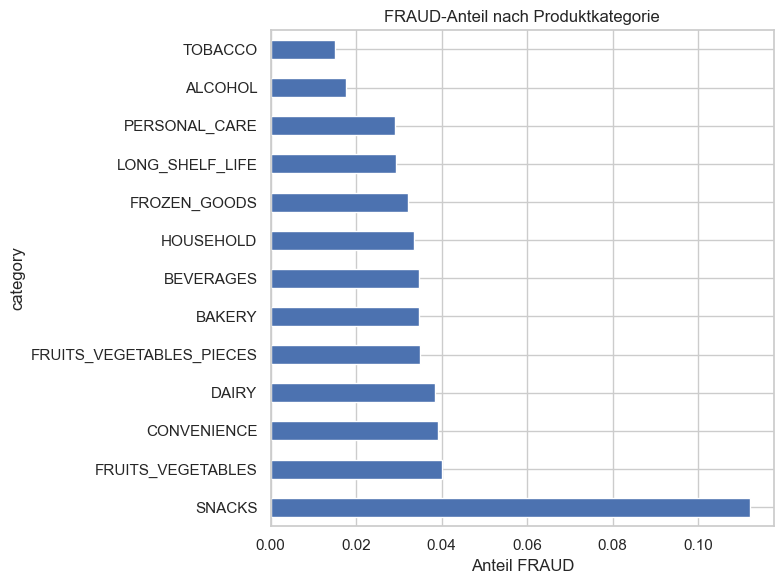

In [68]:
# Visualisierung
import matplotlib.pyplot as plt

fraud_rates = crosstab[1]  # Spalte für FRAUD
fraud_rates.sort_values(ascending=False).plot(kind='barh', figsize=(8, 6))
plt.xlabel('Anteil FRAUD')
plt.title('FRAUD-Anteil nach Produktkategorie')
plt.tight_layout()
plt.show()


In [69]:
# Kontingenztabelle (absolute Häufigkeiten)
contingency = pd.crosstab(joined_tables['category'], joined_tables['label'])

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi² = {chi2:.2f}, p-Wert = {p:.4f}")


Chi² = 854.28, p-Wert = 0.0000


In [ ]:
# Auf Transaktionsebene

# Fraud-Rate je Kategorie mit sauberer Benennung
category_stats = joined_tables.groupby('category').agg(
    total=('label', 'count'),
    fraud_rate=('label', 'mean')
)

# Top 5 Fraud-Kategorien mit mind. 100 Vorkommen
top_fraud_categories = category_stats[category_stats['total'] >= 100] \
    .sort_values('fraud_rate', ascending=False) \
    .head(5).index

# Neue Spalte auf Zeilenebene: ist Top-Fraud-Kategorie?
joined_tables['is_top_fraud_category'] = joined_tables['category'].isin(top_fraud_categories).astype(int)

# Aggregation auf Transaktionsebene
trans_fraud_cat_flag = joined_tables.groupby('transaction_id')['is_top_fraud_category'].max().to_frame()

# Label ebenfalls auf Transaktionsebene
transactions_cat = joined_tables.groupby('transaction_id')['label'].first().to_frame()

# Merge
transactions_cat = transactions_cat.join(trans_fraud_cat_flag)

# Chi²-Test
from scipy.stats import chi2_contingency
ct_cat = pd.crosstab(transactions_cat['is_top_fraud_category'], transactions_cat['label'])
chi2, p, dof, expected = chi2_contingency(ct_cat)

# Ausgabe
print(ct_cat)
print(f"Chi² = {chi2:.2f}, p-Wert = {p:.4f}")


label                       0     1
is_top_fraud_category              
0                       13912   336
1                      136780  4663
Chi² = 36.38, p-Wert = 0.0000


--> Der Chi²-Test zeigt einen **hochsignifikanten Zusammenhang:** Chi² = 854.28 | p-Wert = 0.0000
→ Die Verteilung von Produktkategorien unterscheidet sich signifikant zwischen normalen und betrügerischen Transaktionen.
Die höchste FRAUD-Rate weist die Kategorie SNACKS auf: 11,2 % der SNACK-Produkte treten in als betrügerisch markierten Transaktionen auf.
Deutlich höher als bei allen anderen Kategorien. Kategorien mit besonders niedriger FRAUD-Rate: TOBACCO: nur 1,5 % | ALCOHOL: 1,8 %
→ Die Produktkategorie ist ein signifikanter Prädiktor für verdächtige Transaktionen. In weiteren Modellen sollte category daher berücksichtigt oder codiert werden (z. B. One-Hot oder Target Encoding), insbesondere mit Blick auf die risikobehaftete Kategorie SNACKS.

Transaktionen mit mindestens einer Top-Fraud-Kategorie (aus den 5 auffälligsten Kategorien) sind signifikant häufiger fraudulente Transaktionen als solche ohne.
Allerdings ist der Effekt deutlich schwächer als bei den Produkt-IDs (dort Chi² ≈ 3900) – aber immer noch relevant.
Die Top-Kategorien liefern ein wertvolles erklärendes Merkmal, aber allein nicht so trennscharf wie auffällige Produkt-IDs.

### Analyse product_id vs label

In [70]:
# Fraud-Anteil je Produkt berechnen
product_fraud_stats = joined_tables.groupby('product_id')['label'].agg(['count', 'sum', 'mean']).rename(
    columns={'count': 'total_occurrences', 'sum': 'fraud_count', 'mean': 'fraud_rate'}
)

# Optional: Nur Produkte mit ausreichend Fällen analysieren
product_fraud_stats = product_fraud_stats[product_fraud_stats['total_occurrences'] >= 5]

# Nach Fraud-Rate sortieren
top_fraud_products = product_fraud_stats.sort_values('fraud_rate', ascending=False)


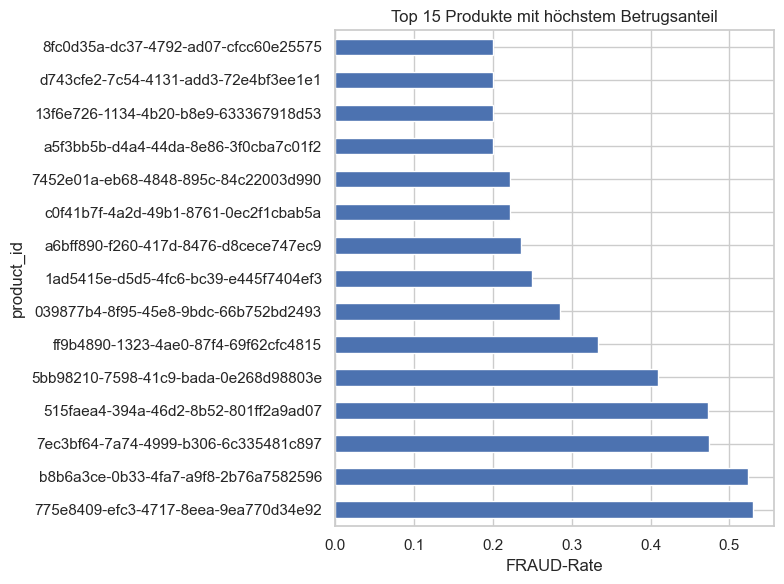

In [71]:
# Visualisierung

top_fraud_products.head(15)['fraud_rate'].plot(kind='barh', figsize=(8,6))
plt.xlabel('FRAUD-Rate')
plt.title('Top 15 Produkte mit höchstem Betrugsanteil')
plt.tight_layout()
plt.show()


In [72]:
# Schritt 1: Fraud-Rate je Produkt berechnen
product_stats = joined_tables.groupby('product_id')['label'].agg(['count', 'mean']).rename(
    columns={'count': 'total', 'mean': 'fraud_rate'}
)

# Nur Produkte mit mindestens 5 Vorkommen berücksichtigen
filtered_products = product_stats[product_stats['total'] >= 5]

# Top 10 Fraud-Produkte holen
top_n = 10
top_fraud_products = filtered_products.sort_values('fraud_rate', ascending=False).head(top_n).index

# Schritt 2: Neue Spalte: Produkt ist auffällig oder nicht
joined_tables['is_top_fraud_product'] = joined_tables['product_id'].isin(top_fraud_products).astype(int)


In [ ]:
# Chi²-Test
# Kontingenztabelle
ct = pd.crosstab(joined_tables['is_top_fraud_product'], joined_tables['label'])

# Chi²-Test
chi2, p, dof, expected = chi2_contingency(ct)
print(f"Chi² = {chi2:.2f}, p-Wert = {p:.4f}")

Chi² = 3549.18, p-Wert = 0.0000


In [75]:
# Logistische Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Merkmale & Ziel
X = joined_tables[['is_top_fraud_product']]
y = joined_tables['label']

# Split & Modell
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

# Ergebnis
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Modellkoeffizient:", model.coef_)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    399044
           1       0.00      0.00      0.00     14442

    accuracy                           0.97    413486
   macro avg       0.48      0.50      0.49    413486
weighted avg       0.93      0.97      0.95    413486

Modellkoeffizient: [[3.1277071]]


c:\Users\sofie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sofie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sofie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [76]:
# Top-Fraud-Produkte (z. B. Top 10)
top_fraud_products = set(top_fraud_products)

# Transaktion enthält eines dieser Produkte
trans_fraud_flag = joined_tables[joined_tables['product_id'].isin(top_fraud_products)] \
    .groupby('transaction_id') \
    .size() \
    .to_frame(name='has_top_fraud_product') \
    .assign(has_top_fraud_product=1)

# Transaktions-Daten mit Label
transactions = joined_tables.groupby('transaction_id')['label'].first().to_frame()

# Merge
transactions = transactions.merge(trans_fraud_flag, how='left', left_index=True, right_index=True)
transactions['has_top_fraud_product'] = transactions['has_top_fraud_product'].fillna(0).astype(int)


In [79]:
# Kontingenztabelle
ct = pd.crosstab(transactions['has_top_fraud_product'], transactions['label'])
print(ct)
chi2, p, dof, expected = chi2_contingency(ct)
print(f"Chi² = {chi2:.2f}, p-Wert = {p:.4f}")


label                       0     1
has_top_fraud_product              
0                      150342  4697
1                         350   302
Chi² = 3901.18, p-Wert = 0.0000


--> Es besteht ein **hochsignifikanter Zusammenhang** zwischen dem Vorkommen bestimmter Produkte und dem Auftreten betrügerischer Transaktionen. (Chi² = 3901.18 | p-Wert = 0.0000)
Transaktionen mit mindestens einem der Top-Fraud-Produkte (nur 650 Transaktionen insgesamt) haben eine FRAUD-Rate von ~46 %: 302 von 650 → 46,5 %
Transaktionen ohne diese Produkte haben nur ~3 % FRAUD: 4 697 von 155 039 → 3,0 %
Das bedeutet: Transaktionen mit diesen Produkten sind mehr als 15× so häufig Fraud wie andere.

### Analyse age_restricted

In [82]:
# Neue Spalte auf Transaktionsebene: enthält altersbeschränktes Produkt?
trans_age_restricted = joined_tables.groupby('transaction_id')['age_restricted'].max().to_frame()

# Label auf Transaktionsebene
transactions_age = joined_tables.groupby('transaction_id')['label'].first().to_frame()

# Merge
transactions_age = transactions_age.join(trans_age_restricted)
transactions_age['age_restricted'] = transactions_age['age_restricted'].fillna(0).astype(int)


In [83]:
# Kontingenztabelle
ct_age = pd.crosstab(transactions_age['age_restricted'], transactions_age['label'])

# Chi²-Test
chi2, p, dof, expected = chi2_contingency(ct_age)

# Ausgabe
print(ct_age)
print(f"Chi² = {chi2:.2f}, p-Wert = {p:.4f}")


label                0     1
age_restricted              
0               147326  4942
1                 3366    57
Chi² = 26.40, p-Wert = 0.0000


--> Die Analyse auf Transaktionsebene zeigt, dass es einen **signifikanten Zusammenhang** zwischen dem Vorhandensein altersbeschränkter Produkte und dem Fraud-Label gibt (Chi² = 26.40, p < 0.001). Allerdings ist der Anteil betrügerischer Transaktionen unter den Transaktionen mit Altersbeschränkung geringer als ohne.
Diese Erkenntnis kann z. B. zur Negativgewichtung dieser Eigenschaft im Modell führen oder zur Modellkalibrierung beitragen.

### Analyse 'sold_by_weight'

In [84]:
# Für jede Transaktion prüfen: gab es ein gewichtsverkauftes Produkt?
trans_weight = joined_tables.groupby('transaction_id')['sold_by_weight'].max().to_frame()

# Label ergänzen
transactions_weight = joined_tables.groupby('transaction_id')['label'].first().to_frame()
transactions_weight = transactions_weight.join(trans_weight)

# Datentyp korrigieren (falls NaN)
transactions_weight['sold_by_weight'] = transactions_weight['sold_by_weight'].fillna(0).astype(int)


In [85]:
# Kontingenztabelle
ct_weight = pd.crosstab(transactions_weight['sold_by_weight'], transactions_weight['label'])

# Chi²-Test
chi2, p, dof, expected = chi2_contingency(ct_weight)

# Ausgabe
print(ct_weight)
print(f"Chi² = {chi2:.2f}, p-Wert = {p:.4f}")


label                0     1
sold_by_weight              
0               147161  4858
1                 3531   141
Chi² = 4.58, p-Wert = 0.0323


--> Der Chi²-Test zeigt einen signifikanten, aber **schwachen Zusammenhang zwischen Transaktionen mit gewichtsverkauften Produkten** und dem Fraud-Label (Chi² = 4.58, p = 0.032). Der beobachtete Effekt ist geringer als bei anderen untersuchten Merkmalen, weist jedoch auf ein potenziell relevantes Risikosignal hin, das in die Modellbildung einbezogen werden kann.